USEFUL LINKS FOR DATA CLEANING:

https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/?utm_source=blog&utm_medium=stockmarketpredictionarticle

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [1]:
import pandas as pd
import calendar as cd
import numpy as np
import os

DIRTY_FILE_NAME = 'ES=F.csv'
CLEAN_FILE_NAME = '(Clean)dowjones_stocks.csv'

## DATA EXTRACTION AND CLEANING AND FORMATTING
### Data Extraction
Putting the dow jones csv data into a dataframe

In [2]:
if os.path.exists(DIRTY_FILE_NAME):
    dowjones_stocks = pd.read_csv(DIRTY_FILE_NAME)
    print(dowjones_stocks.head())
else:
    print("Error: Input file not found")

         Date     Open     High      Low   Close  Adj Close    Volume
0  2000-09-18  1485.25  1489.75  1462.25  1467.5     1467.5  104794.0
1  2000-09-19  1467.00  1482.75  1466.75  1478.5     1478.5  103371.0
2  2000-09-20  1478.75  1480.50  1450.25  1469.5     1469.5  109667.0
3  2000-09-21  1470.25  1474.00  1455.50  1469.5     1469.5   98528.0
4  2000-09-22  1454.75  1471.00  1436.75  1468.5     1468.5   97416.0


### Data Cleaning

The Dow Jones stock price dataset contains a number of null records typically during holidays or weekends, which are days when the stock market is closed. To clean this dataset, we will simply remove all null records. Due to the missing dates, it should be noted that the stock price forecasting model will not predict stock prices for each subsequent days. Rather, we should assume that the forecasting model will predict stock prices for the next subsequent day in which the stock price would typically be observed and recorded.

In [3]:
dowjones_stocks_cleaned = dowjones_stocks.loc[dowjones_stocks["Open"].isnull() == False]
dowjones_stocks

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,1485.25,1489.75,1462.25,1467.50,1467.50,104794.0
1,2000-09-19,1467.00,1482.75,1466.75,1478.50,1478.50,103371.0
2,2000-09-20,1478.75,1480.50,1450.25,1469.50,1469.50,109667.0
3,2000-09-21,1470.25,1474.00,1455.50,1469.50,1469.50,98528.0
4,2000-09-22,1454.75,1471.00,1436.75,1468.50,1468.50,97416.0
...,...,...,...,...,...,...,...
6190,2020-11-17,3625.50,3630.00,3584.25,3606.75,3606.75,1268206.0
6191,2020-11-18,3604.50,3623.25,3556.50,3565.00,3565.00,1325309.0
6192,2020-11-19,3562.00,3582.75,3542.25,3580.00,3580.00,1291117.0
6193,2020-11-20,3560.00,3582.50,3542.75,3554.25,3554.25,1189621.0


Check if there are any null values left in the dataset. There are none left.

In [4]:
dowjones_stocks_cleaned.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
#save cleaned data without the index column.
dowjones_stocks_cleaned.to_csv(CLEAN_FILE_NAME, index=0)

## BREAK POINT 1: Data Cleaned and saved till here. Can begin from here if saved file is available

In [6]:
if os.path.exists(CLEAN_FILE_NAME):
    dowjones_stocks_cleaned = pd.read_csv(CLEAN_FILE_NAME,index_col=['Date'])
    print(dowjones_stocks_cleaned.head())
else:
    print("Error: Clean File not found. Restart from the beginning")

               Open     High      Low   Close  Adj Close    Volume
Date                                                              
2000-09-18  1485.25  1489.75  1462.25  1467.5     1467.5  104794.0
2000-09-19  1467.00  1482.75  1466.75  1478.5     1478.5  103371.0
2000-09-20  1478.75  1480.50  1450.25  1469.5     1469.5  109667.0
2000-09-21  1470.25  1474.00  1455.50  1469.5     1469.5   98528.0
2000-09-22  1454.75  1471.00  1436.75  1468.5     1468.5   97416.0


# Model: CNN

We have 10 years work of data. Will use 9 years of data to predict the last year.
Will break the data down into weekly data and then use that to predict the daily high for each daya for a week.

In [7]:
def split(dataset):
    dataset = dataset.values
    length = len(dowjones_stocks_cleaned)
    print("Length=",length)
    total_weeks = int(length/5)
    print("Total Weeks=",total_weeks)
    
    #use last 1 year as test data set, everything else as train dataset
    WEEKS_IN_ONE_YEAR = 52
    ONE_YEAR_WORK_DAYS = 5*52
    
    train = dataset[0:-ONE_YEAR_WORK_DAYS]
    test = dataset[-ONE_YEAR_WORK_DAYS:]
    
    #convert to array
    train = np.array(train)
    test = np.array(test)
    
    print("-----TRAIN DATA-----")
    print("Length=",len(train))
    print("-----TEST DATA-----")
    print("Length=",len(test))
    print(test[0])
    return train,test
    
train_data,test_data = split(dowjones_stocks_cleaned)

Length= 5131
Total Weeks= 1026
-----TRAIN DATA-----
Length= 4871
-----TEST DATA-----
Length= 260
[   3237.      3261.75    3234.25    3259.      3259.   1416241.  ]


### What to predict?
Use the available data: Open Price, High, Low, Close, Adj Close, Volume to predict the High of next 1 week

In [8]:
COLUMN_TO_PREDICT = 1 #High for the day
NUMBER_OF_DAYS_DATA_TO_USE = 5
NUMBER_OF_COLUMNS = train_data.shape[1]
#split the given data into inputs and outputs. We can use last 7 days data to predict the next day 
# or we can use monthly data to predict. It depends onm how we want to model the data
# and will experiment with various models
#if column_with_result is None, then trying to make data for validation
def convert_data_into_io(input_data, steps, column_with_result):
    print(column_with_result)
    x,y = list(), list()
    
    for i in range(len(input_data)):
        end = i + steps
        if end+1 > len(input_data):
            break
        
        _x = input_data[i:end,]
        _y = input_data[end,column_with_result]
        
        y.append(_y)
        x.append(_x)
        
    return np.array(x), np.array(y)

In [9]:
x,y = convert_data_into_io(train_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT)

print("Sample Input Data:")
print(x[0])
print("Sample Output Data:")
print(y[0])

1
Sample Input Data:
[[  1485.25   1489.75   1462.25   1467.5    1467.5  104794.  ]
 [  1467.     1482.75   1466.75   1478.5    1478.5  103371.  ]
 [  1478.75   1480.5    1450.25   1469.5    1469.5  109667.  ]
 [  1470.25   1474.     1455.5    1469.5    1469.5   98528.  ]
 [  1454.75   1471.     1436.75   1468.5    1468.5   97416.  ]]
Sample Output Data:
1477.75


In [10]:
from keras.layers import Dense
from keras import Input
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.layers import Flatten
from keras.callbacks import Callback

EPOCHS=10000

class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('.',end='')
    if epoch % 1000 == 0: print(': ',epoch)
        
# define model
def model_and_fit(x,y, modelFile):
    if os.path.exists(modelFile):
        #delete file
        os.remove(modelFile)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(NUMBER_OF_DAYS_DATA_TO_USE, NUMBER_OF_COLUMNS)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1)) #only 1 output
    model.compile(optimizer='adam', loss='mae')
    model.fit(x,y, epochs=EPOCHS, verbose=0, callbacks=[PrintDot()])
    #save model
    model.save(modelFile)
    print("Model fitted and saved!")
    return model


In [14]:
#SAVE MODEL AFTER FITTING. If saved model is available, then reload that
from keras.models import load_model
SAVED_MODEL_NAME = "CNN_ModelSaved"
model = None

if os.path.exists(SAVED_MODEL_NAME):
    print("Model Found: Loading...")
    model = load_model(SAVED_MODEL_NAME)
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model = model_and_fit(x,y,SAVED_MODEL_NAME)
    

Model Found: Loading...
Model Loaded!


In [2]:
#function for preditions and error calculating
def predict(model, input_data):
    input_data = input_data.reshape(1,NUMBER_OF_DAYS_DATA_TO_USE,NUMBER_OF_COLUMNS)
    value = model.predict(input_data, verbose=0)
    return value[0][0]


def check_all_test_data(data, model):
    predicted_data = []
    i = 1
    for d in data:
        print('.',end='')
        if i%20 == 0: print('-',i)
        d = d.reshape((1, NUMBER_OF_DAYS_DATA_TO_USE, NUMBER_OF_COLUMNS))
        data = predict(model,d)
        predicted_data.append(data)
        i = i+1
    print('-',i)
    return predicted_data

test_x,actual_y = convert_data_into_io(test_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT)
print("Start predicting data...")
predicted_y = check_all_test_data(test_x, model)
print("End of data prediction!")

NameError: name 'convert_data_into_io' is not defined

In [1]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import math 

#plot actual and predicted
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y, label='predicted data')
plt.plot(x_axis, actual_y, label='actual data')
plt.legend()


NameError: name 'np' is not defined

RMSE =  50.05688447626161


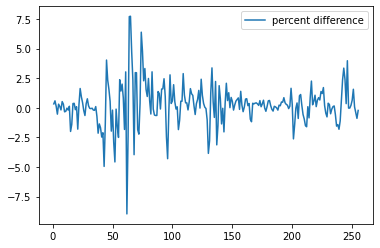

In [21]:
#print RMSE
mse = mean_squared_error(actual_y, predicted_y)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

def percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100

#get percent difference between actual and predicted
difference = []
for i in range(0,len(actual_y)):
    difference.append(percent_diff(actual_y[i],predicted_y[i]))

x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, difference, label='percent difference')
plt.legend()
